In [500]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import statsmodels.formula.api as smf
import scipy as sp
from scipy import stats
from scipy.stats import t, shapiro
from scipy.stats import kurtosis
import plotly.express as px
import joblib as jl

# 📖**Projet 10 Détectez des faux billets avec Python**

**Le contexte du projet de data analyse**

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM,
est une organisation publique ayant pour objectif de mettre en place des
méthodes d’identification des contrefaçons des billets en euros.

Notre mission est construire un algorithme qui, à partir des caractéristiques
géométriques d’un billet, serait capable de définir si ce dernier est un vrai
ou un faux billet.

## Le jeu de données

L'ouverture de la base de données pour la modélisation d'algorithme.

In [501]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [502]:
df_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P10/billets.csv', sep = ';')
df_org.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [503]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [504]:
df_org.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Il y a 37 valeurs manquantes pour la colonne 'margin_low'.

In [505]:
df_org.shape

(1500, 7)

is_genuine
False     500
True     1000
Name: is_genuine, dtype: int64

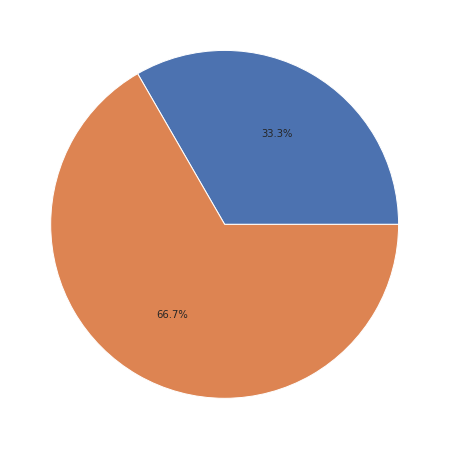

In [506]:
df_count = df_org.groupby('is_genuine')['is_genuine'].count()
plt.figure(figsize=(12,8))
plt.pie(df_count, autopct="%.1f%%")
df_count

1000 vrais billets et 500 faux billets

# Traiter les valeurs manquantes avec la régression linéaire

## Normalisation

In [507]:
# Centrage et réduction
df_norm = df_org.copy()

# Sélectionner que les colonnes numériques
numeric_range = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
scaled_org = preprocessing.StandardScaler().fit_transform(df_norm[numeric_range])
df_norm[numeric_range] = scaled_org

# Vérifier les distributions de données
df_norm.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1.500000e+03,1.500000e+03,1.500000e+03,1.463000e+03,1.500000e+03,1.500000e+03
mean,-7.850550e-14,4.812743e-14,-2.783433e-14,2.719781e-16,-9.852859e-16,4.547474e-16
std,1.000334e+00,1.000334e+00,1.000334e+00,1.000342e+00,1.000334e+00,1.000334e+00
min,-3.010357e+00,-2.971432e+00,-3.380166e+00,-2.269439e+00,-3.803785e+00,-3.654697e+00
25%,-6.832007e-01,-6.999333e-01,-6.460667e-01,-7.097308e-01,-6.967992e-01,-7.433186e-01
50%,5.113189e-03,3.496326e-02,-9.420867e-04,-2.651763e-01,-4.951040e-02,3.226587e-01
75%,6.934271e-01,6.696467e-01,7.056229e-01,5.787237e-01,6.840835e-01,7.582193e-01
max,3.446683e+00,2.840932e+00,3.163240e+00,3.637861e+00,3.273239e+00,2.019053e+00


**Avant normalisation**

Text(0.5, 1.0, 'La distribution des données avant normalisation')

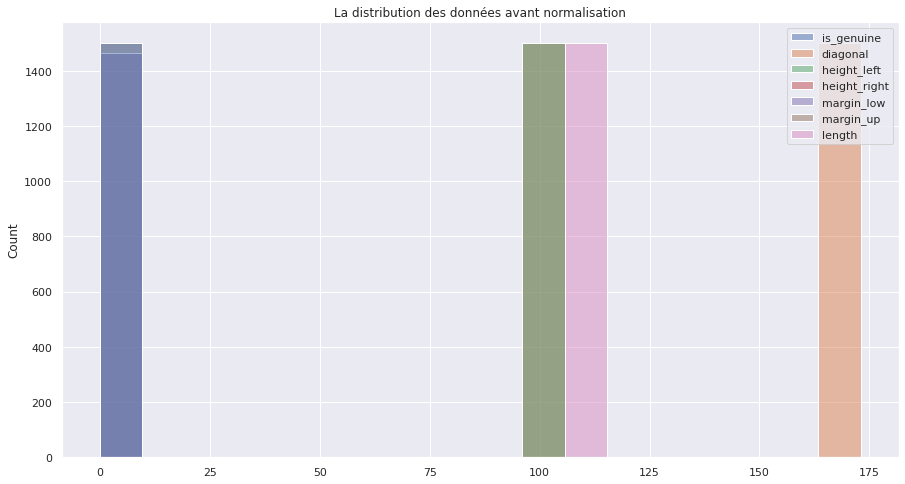

In [508]:
# Visualisation des données avant normalisation
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(df_org)
plt.title('La distribution des données avant normalisation')

**Après normalization**

Text(0.5, 1.0, 'La distribution des données après normalisation')

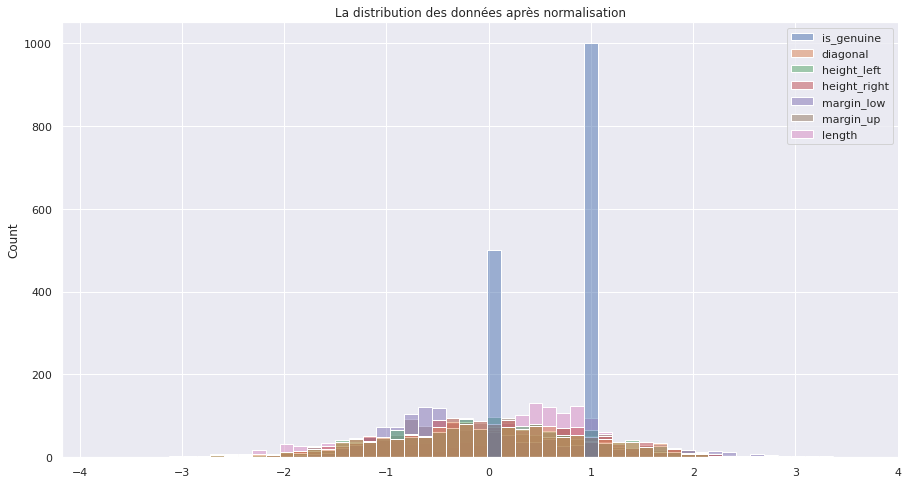

In [509]:
# Visualisation des données après normalisation
sns.histplot(df_norm)
plt.title('La distribution des données après normalisation')

## Comprendre margin_low

### La distribution normale

Text(0.5, 1.0, "Visualisation la distribution de 'margin_low'")

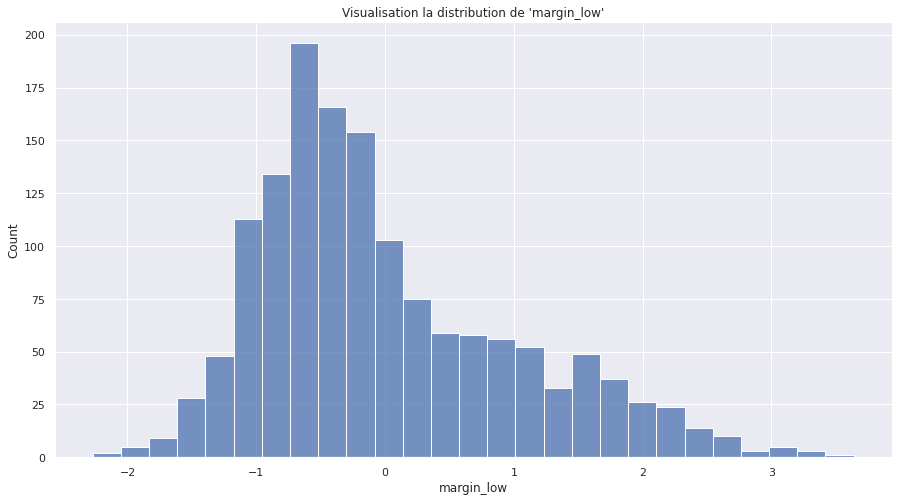

In [510]:
# Visualisation la distribution de 'margin_low'
sns.histplot(df_norm['margin_low'])
plt.title("Visualisation la distribution de 'margin_low'")

Verifier la normalité avec Test Shapiro-Wilk

In [511]:
# Test loi normalité
stat_shapiro, p_shapiro = stats.shapiro(df_norm['margin_low'])
print('Statistics=%.3f, p=%.3f' % (stat_shapiro, p_shapiro))
# Interpréter résultats
alpha = 0.05
if p_shapiro > alpha:
    print("L'hypothèse de normalité est donc tolérée (accepte H0)")
else:
    print("L'hypothèse de normalité est donc rejetée (rejete H0)")

Statistics=nan, p=1.000
L'hypothèse de normalité est donc tolérée (accepte H0)


### Carte thermique de corrélation triangulaire

Text(0.5, 1.0, 'Explorer les données avec carte thermique de corrélation triangulaire')

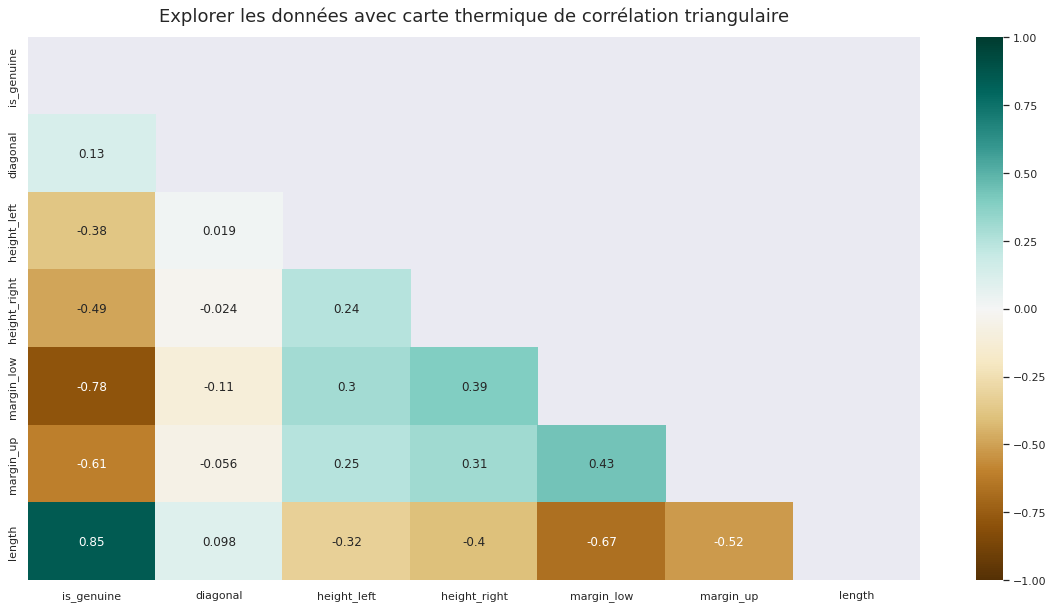

In [512]:
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(df_norm.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df_norm.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Explorer les données avec carte thermique de corrélation triangulaire', fontdict={'fontsize':18}, pad=16)

### Relation linéaire avec pairplot

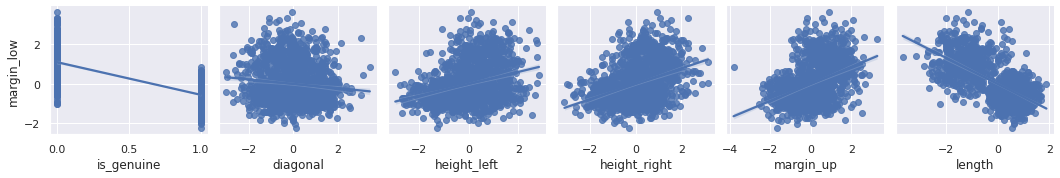

In [513]:
sns.pairplot(df_norm, x_vars=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length'], y_vars= 'margin_low', kind='reg')

**Comprendre 'margin_low', qu'il y a des valeurs manquantes:**

*   Il est corrélé avec 'is_genuine', 'margin_low' et 'length'
*   'Margin_low' est une variable quantitative, qui répère la loi de normalité
*   Il y a de la relation linéaire avec 'is_genuine', 'margin_up' et 'length'. On peut utiliser une régression linéaire pour la prévision.






## Régression Linéaire

Explication la méthode:

Le modèle de régression linéaire multiple considère qu'il existe une relation linéaire entre Y et nos p variables explicatives.

*   Y est une v.a.r, quantivative observable;
*   Expliquée, modélisée par plusieurs variables quantivatives (X1-Xp);
*   (β1,…,βp) sont des paramètres inconnus (non observables) ;
*   ε , l'erreur du modèle, est une v.a.r centrée de variance σ2 inconnue (c'est également un paramètre du modèle).



### Séparer les dataset pour training, testing et predict

In [514]:
X = df_norm[df_norm['margin_low'].notnull()].drop(columns = 'margin_low')
y = df_norm[df_norm['margin_low'].notnull()]['margin_low']

In [515]:
# Séparer les dataset pour training et testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3)

In [516]:
# Vérifier les parties de données de trainning et testing
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1024, 6)
X_test shape: (439, 6)
y_train shape: (1024,)
y_test shape: (439,)


### Modèle de régression linéaire avec librairie statsmodels

#### Retirer les variables non significatives

##### Tous les variables

In [517]:
# Créer le modèle et le résumé
X_train_sm = sm.add_constant(X_train).astype(float)
model = sm.OLS(y_train, X_train_sm)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     261.2
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          5.74e-202
Time:                        19:13:05   Log-Likelihood:                -965.30
No. Observations:                1024   AIC:                             1945.
Df Residuals:                    1017   BIC:                             1979.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.1604      0.063     18.489   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



**Explanation des coefficients:**


**Le coefficient de détermination  R2**

SCE (Somme des Carrés Expliquée)/SCT (Somme des Carrés Résiduelle) dans [0,1] défini par : 

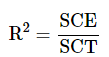

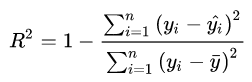

Dans le cas de la régression avec constante :

Si R2=1 , on a alors SCE=SCT : toute la variation est expliquée par le modèle.

Si R2=0 , on a alors SCR=SCT : aucune variation n'est expliquée par le modèle.


**Une statistique de Fisher**
Un test global pour la significativité du modèle global. en pratique, l'hypothèse Ho de ce test est souvent rejetée, le modèle est donc souvent significatif globalement.

**P valeur pour le T test**
Un test de significativité sur chacune des variables explicatives prises une à une par le test de Student. Ici, tester l'un des paramètres a un réel sens : si une variable n'est pas significative, il faut la retirer du modèle. Si l'on ne la retire pas, il est possible que l'erreur de prévision du modèle soit plus élevée.

**Test pour la significativité**

**Une statistique de Fisher**
 
Un test global pour la significativité du modèle global. en pratique, l'hypothèse Ho de ce test est souvent rejetée, le modèle est donc souvent significatif globalement.

**P valeur pour le T test** 

Un test de significativité sur chacune des variables explicatives prises une à une par le test de Student. Ici, tester l'un des paramètres a un réel sens : si une variable n'est pas significative, il faut la retirer du modèle. Si l'on ne la retire pas, il est possible que l'erreur de prévision du modèle soit plus élevée.

**L' analyse de rapport:**

**Les P valeurs pour les variables 'diagonal' et 'length' sont plus de 0.05, qui sont les moins significative. On les enlèves donc.**

**Procédure descendante ou backward:**

On initialise la procédure en intégrant tous les régresseurs, puis on élimine à chaque pas le régresseur associé à la plus petite diminution de la somme des carrés expliqués (la constante est toujours conservée).

##### 4 Variables

In [518]:
# Créer la dataframe avec les 3 variables les plus corrélés
df_4_var = df_norm[['is_genuine', 'height_left', 'height_right', 'margin_up', 'margin_low']]
df_4_var.head()

,is_genuine,height_left,height_right,margin_up,margin_low
0,True,2.774123,3.163240,-1.128325,0.051286
1,True,-2.236535,-0.799668,-0.696799,-1.078937
2,True,1.504756,-1.291191,-0.912562,-0.129549
3,True,-0.399294,0.060498,-0.610494,-1.304982
4,True,0.836669,-1.414072,1.417677,-0.672057


In [519]:
X_4_var = df_4_var[df_4_var['margin_low'].notnull()].drop(columns = 'margin_low')
y_4_var = df_4_var[df_4_var['margin_low'].notnull()]['margin_low']

# Séparer les dataset pour training et testing
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_4_var, y_4_var, test_size = 0.3)

In [520]:
# Vérifier les parties de données de trainning et testing
print('X_train_4 shape: ' + str(X_train_4.shape))
print('X_test_4 shape: ' + str(X_test_4.shape))
print('y_train_4 shape: ' + str(y_train_4.shape))
print('y_test_4 shape: ' + str(y_test_4.shape))

X_train_4 shape: (1024, 4)
X_test_4 shape: (439, 4)
y_train_4 shape: (1024,)
y_test_4 shape: (439,)


In [521]:
# Créer le modèle et le résumé
X_train_sm4 = sm.add_constant(X_train_4).astype(float)
model4 = sm.OLS(y_train_4, X_train_sm4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     378.1
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          1.40e-199
Time:                        19:13:05   Log-Likelihood:                -994.96
No. Observations:                1024   AIC:                             2000.
Df Residuals:                    1019   BIC:                             2025.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.1382      0.044     25.645   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



**Le P valeur pour 'height_right' est plus de 0.05, qui est le moin significative. On l'enlèves donc.**

##### 3 Variables

In [522]:
# Créer la dataframe avec les 3 variables les plus corrélés
df_3_var = df_norm[['is_genuine', 'height_left', 'margin_up', 'margin_low']]
df_3_var.head()

,is_genuine,height_left,margin_up,margin_low
0,True,2.774123,-1.128325,0.051286
1,True,-2.236535,-0.696799,-1.078937
2,True,1.504756,-0.912562,-0.129549
3,True,-0.399294,-0.610494,-1.304982
4,True,0.836669,1.417677,-0.672057


In [523]:
X_3_var = df_3_var[df_3_var['margin_low'].notnull()].drop(columns = 'margin_low')
y_3_var = df_3_var[df_3_var['margin_low'].notnull()]['margin_low']

# Séparer les dataset pour training et testing
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3_var, y_3_var, test_size = 0.3)

In [524]:
# Vérifier les parties de données de trainning et testing
print('X_train_3 shape: ' + str(X_train_3.shape))
print('X_test_3 shape: ' + str(X_test_3.shape))
print('y_train_3 shape: ' + str(y_train_3.shape))
print('y_test_3 shape: ' + str(y_test_3.shape))

X_train_3 shape: (1024, 3)
X_test_3 shape: (439, 3)
y_train_3 shape: (1024,)
y_test_3 shape: (439,)


In [525]:
# Créer le modèle et le résumé
X_train_sm3 = sm.add_constant(X_train_3).astype(float)
model3 = sm.OLS(y_train_3, X_train_sm3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     547.3
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          6.98e-212
Time:                        19:13:05   Log-Likelihood:                -959.53
No. Observations:                1024   AIC:                             1927.
Df Residuals:                    1020   BIC:                             1947.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1950      0.041     29.035      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



**Le P valeur pour 'height_left' est plus de 0.05, qui est le moin significative. On l'enlèves donc.**

##### 2 Variables

In [526]:
# Créer la dataframe avec les 3 variables les plus corrélés
df_2_var = df_norm[['is_genuine', 'margin_up', 'margin_low']]
df_2_var.head()

,is_genuine,margin_up,margin_low
0,True,-1.128325,0.051286
1,True,-0.696799,-1.078937
2,True,-0.912562,-0.129549
3,True,-0.610494,-1.304982
4,True,1.417677,-0.672057


In [527]:
X_2_var = df_2_var[df_2_var['margin_low'].notnull()].drop(columns = 'margin_low')
y_2_var = df_2_var[df_2_var['margin_low'].notnull()]['margin_low']

# Séparer les dataset pour training et testing
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2_var, y_2_var, test_size = 0.3)

In [528]:
# Vérifier les parties de données de trainning et testing
print('X_train_2 shape: ' + str(X_train_2.shape))
print('X_test_2 shape: ' + str(X_test_2.shape))
print('y_train_2 shape: ' + str(y_train_2.shape))
print('y_test_2 shape: ' + str(y_test_2.shape))

X_train_2 shape: (1024, 2)
X_test_2 shape: (439, 2)
y_train_2 shape: (1024,)
y_test_2 shape: (439,)


In [529]:
# Créer le modèle et le résumé
X_train_sm2 = sm.add_constant(X_train_2).astype(float)
model2 = sm.OLS(y_train_2, X_train_sm2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     832.3
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          3.88e-215
Time:                        19:13:05   Log-Likelihood:                -959.97
No. Observations:                1024   AIC:                             1926.
Df Residuals:                    1021   BIC:                             1941.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1465      0.039     29.207      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



1.   Prob (F-statistic) est inférieur à 0.05, le modèle globale est corrélé avec 'margin_low'.
2.   Les variables 'is_genuine' et 'margin_up' sont significativement corrélés avec 'margin_low'.




#### Vérifier la colinéarité des variables

In [530]:
variables = result2.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.6279424532077216, 1.6279424532077216]

Tous les coefficients sont inférieurs à 5, il n'y a donc pas de problème de colinéarité.

#### Tester l’homoscédasticité (Constant Error Variance)

In [531]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(result2.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.9267726022230334e-23


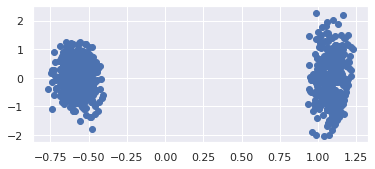

In [532]:
y_pred = result2.predict(X_train_sm2)
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, result2.resid)

• H0 : homoscédasticité
• H1 : hétéroscédasticité

Si la probabilité associée au test est inférieure à α, on rejette l’hypothèse d’homoscédasticité (H0). En revanche, si la probabilité est supérieure à α, l’hypothèse nulle est vérifiée et nous pouvons supposer l’homoscédasticité des résidus. Avec α = 5% = seuil de significativité.

La p-valeur ici est inférieure à  5 %, on rejette l'hypothèse  H0  selon laquelle les variances ne sont pas constantes (hétéroscédasticité).

#### Tester la normalité des résidus

##### L'histogramme

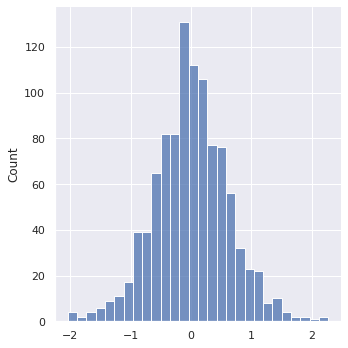

In [533]:
sns.displot(result2.resid)

##### Test de Shapiro

In [534]:
shapiro(result2.resid)

ShapiroResult(statistic=0.9948773980140686, pvalue=0.0015356993535533547)

##### Moyenne

In [535]:
np.mean(result2.resid)

-5.478256737134757e-15

##### QQ plot

Text(0.5, 1.0, 'Q-Q Plot pour le test normalité de résidus')

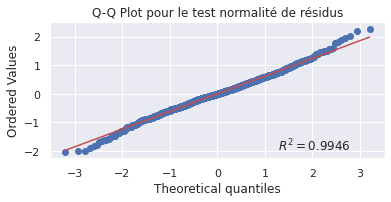

In [536]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(result2.resid, plot=ax, fit=True, rvalue = True)
plt.title("Q-Q Plot pour le test normalité de résidus")

**Ici, l'hypothèse de normalité est remise en cause.**

**Par contre, on a vérifié la distribution de résidus par l'histrogramme, le QQ plot, et la calculation de moyenne de résidus. Les résultats nous indiquent qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 1000) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le test la normalité résidu par le test Shapiro n'est pas considéré comme étant gaussien.**

### Créer le modèle avec Sklearn avec les 2 variables

In [537]:
# Training l'algorithme
lr_2 = LinearRegression()
lr_2.fit(X_train_2, y_train_2)

LinearRegression()

In [538]:
# Les scores de training et testing sets
print("Training set score avec 2 variables: {:.2f}".format(lr_2.score(X_train_2, y_train_2)))
print("Test set score avec 2 variables: {:.2f}".format(lr_2.score(X_test_2, y_test_2)))

Training set score avec 2 variables: 0.62
Test set score avec 2 variables: 0.61


In [539]:
# Les scores et les coefficients
y_t_predit2 = lr_2.predict(X_test_2)
r2_2 = r2_score(y_test_2, y_t_predit2).round(2)

print('Intercept: {:.2f}'.format(lr_2.intercept_))
print('Coefficients: ' + str(lr_2.coef_))
print('R2 score: ' + str(r2_2))
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test_2, y_t_predit2).round(2)))
print('Mean absolute error MAE: {:.2f}'.format(mean_absolute_error(y_test_2, y_t_predit2).round(2)))
print('Median absolute error: {:.2f}'.format(median_absolute_error(y_test_2, y_t_predit2).round(2)))

Intercept: 1.15
Coefficients: [-1.75434075 -0.07875528]
R2 score: 0.61
Mean squared error: 0.39
Mean absolute error MAE: 0.48
Median absolute error: 0.39


**Explanation des formules:**

**R2**

On appelle coefficient de détermination, noté R2 , le réel dans [0,1] défini par : 

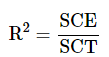

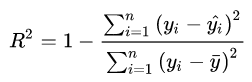

Dans le cas de la régression avec constante :

Si R2=1 , on a alors SCE=SCT : toute la variation est expliquée par le modèle.

Si R2=0 , on a alors SCR=SCT : aucune variation n'est expliquée par le modèle.



**Mean squared error**

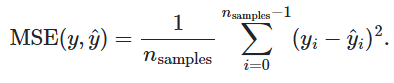

**Analyse des scores:**



*   Le modèle avec 3 variables corrélés a de meilleures performance que l'autre modèle avec tous les variables concernant R2 score (plus proche à 1) et Mean squared error (le plus petit)





### Ridge

Ultiliser un autre methode de provision

In [540]:
ridge = Ridge().fit(X_train_2, y_train_2)

In [541]:
print("Training set score: {:.2f}".format(ridge.score(X_train_2, y_train_2)))
print("Test set score: {:.2f}".format(ridge.score(X_test_2, y_test_2)))

Training set score: 0.62
Test set score: 0.61


##Imputer les valeurs manquants avec régression linéaire

In [542]:
# Créer le dataframe avec données not null
df_full = df_norm[df_norm['margin_low'].notnull()]

In [543]:
# Créer le dataframe avec valeurs manquantes
df_null = df_norm[df_norm['margin_low'].isnull()]
df_null

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,-0.060441,-0.466103,-1.444792,NaN,0.425168,0.127803
99,True,-0.093217,0.135176,0.797784,NaN,-0.049510,0.460204
151,True,0.365659,-0.766742,1.412188,NaN,-0.567341,0.288272
197,True,-1.666506,-1.234404,-0.369585,NaN,2.021814,0.677984
241,True,-0.420986,0.369007,0.429141,NaN,-0.567341,-0.365069
251,True,-0.519316,-2.570579,-3.380166,NaN,-0.869409,0.620674
284,True,-0.125994,-0.666529,-0.492466,NaN,0.338863,0.700909
334,True,-0.355432,-1.100786,0.121939,NaN,-0.653647,0.781144
410,True,1.971724,-1.033977,-1.260471,NaN,-0.135816,0.311197
413,True,1.119526,-1.234404,-1.291191,NaN,0.036795,0.311197


In [544]:
# Créer le data set pour prévision
X_predit = df_null[['is_genuine', 'margin_up']]

# Prédire les 'margin_low'
null_predict = lr_2.predict(X_predit)
null_predict

array([-0.64128794, -0.60390451, -0.56312259, -0.76703221, -0.56312259,
       -0.53933313, -0.63449095, -0.5563256 , -0.59710752, -0.6107015 ,
       -0.55972409, -0.45776928, -0.54952861, -0.65828041, -0.45437079,
       -0.40679188, -0.58011506, -0.58691204, -0.63788945, -0.60050602,
       -0.55972409, -0.55292711, -0.52234066, -0.58011506, -0.54952861,
       -0.41358886, -0.56312259, -0.64808493, -0.55292711,  1.12664679,
        1.14024076,  1.19121817,  1.22180461,  1.06207541,  0.99070704,
        1.00769951,  1.1164513 ])

In [545]:
# Remplir les valeurs manquantes
df_norm.loc[df_null.index, ('margin_low')] = lr_2.predict(X_predit)
df_norm.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1.500000e+03,1.500000e+03,1.500000e+03,1500.000000,1.500000e+03,1.500000e+03
mean,-7.850550e-14,4.812743e-14,-2.783433e-14,-0.005103,-9.852859e-16,4.547474e-16
std,1.000334e+00,1.000334e+00,1.000334e+00,0.994437,1.000334e+00,1.000334e+00
min,-3.010357e+00,-2.971432e+00,-3.380166e+00,-2.269439,-3.803785e+00,-3.654697e+00
25%,-6.832007e-01,-6.999333e-01,-6.460667e-01,-0.690894,-6.967992e-01,-7.433186e-01
50%,5.113189e-03,3.496326e-02,-9.420867e-04,-0.265176,-4.951040e-02,3.226587e-01
75%,6.934271e-01,6.696467e-01,7.056229e-01,0.578724,6.840835e-01,7.582193e-01
max,3.446683e+00,2.840932e+00,3.163240e+00,3.637861,3.273239e+00,2.019053e+00


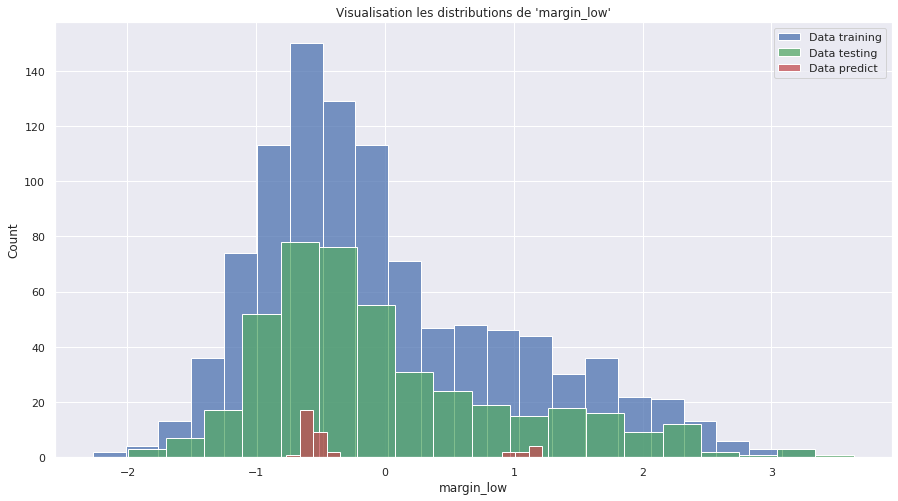

In [546]:
# Visualisation des data sets de training, testing et predict
f, ax = plt.subplots(1, 1)
sns.histplot(y_train_2, label = 'Data training', ax=ax)
sns.histplot(y_test_2, label = 'Data testing', color = 'g', ax=ax)
sns.histplot(null_predict, color = 'r', label = 'Data predict', ax=ax)
plt.title("Visualisation les distributions de 'margin_low'")
ax.legend()

# Explorer des données



## Pairplot

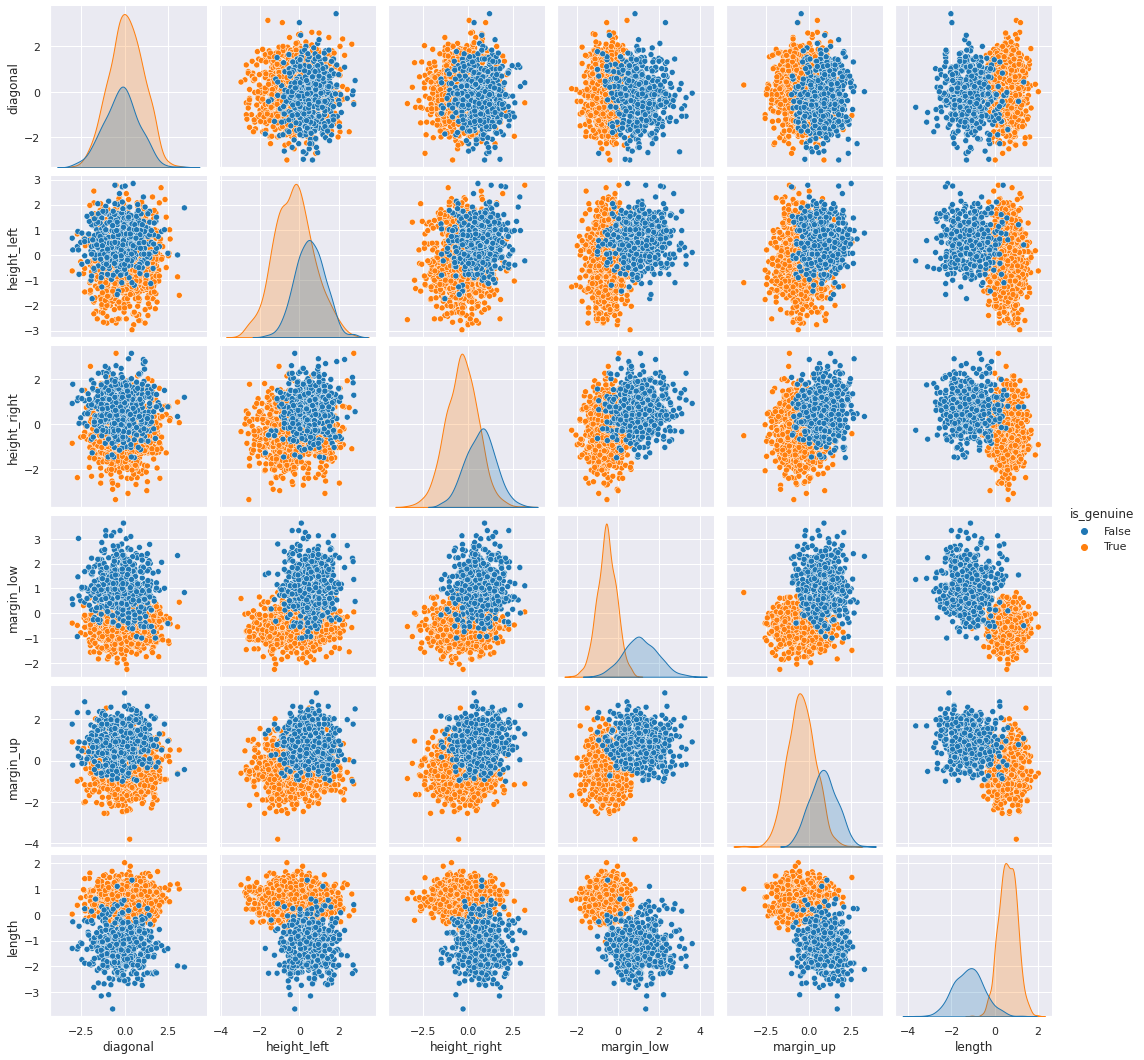

In [547]:
# Créer pairplot pour toutes les variables
sns.pairplot(df_norm, hue= 'is_genuine', vars = ['diagonal',
                   'height_left',
                   'height_right',
                   'margin_low',
                   'margin_up',
                   'length'], palette='tab10')

On peut voir dans le pairplot qu'il y a des corrélation entre les variables et les clusters.

## Distribution et normalité

In [548]:
shap = []

for column in df_norm:
    for i in [True, False]:
      dft = df_norm[df_norm['is_genuine'] == i]
      stat, pval = shapiro(dft[column])
      H0 = 'Hypothèse 0, non rejetée' if pval > alpha else "Hypotèse rejetée"
      shap.append((i, column, stat, pval, H0))
pd.DataFrame(shap, columns=('Athenticité du billet', 'Dimension', 'Stat', 'P-valeur', 'Hypothèse')).set_index('Dimension')

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1757: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



,Athenticité du billet,Stat,P-valeur,Hypothèse
Dimension,,,,
is_genuine,True,1.000000,1.000000,"Hypothèse 0, non rejetée"
is_genuine,False,1.000000,1.000000,"Hypothèse 0, non rejetée"
diagonal,True,0.998064,0.310298,"Hypothèse 0, non rejetée"
diagonal,False,0.997435,0.638479,"Hypothèse 0, non rejetée"
height_left,True,0.996582,0.028577,Hypotèse rejetée
height_left,False,0.997877,0.790749,"Hypothèse 0, non rejetée"
height_right,True,0.998551,0.588416,"Hypothèse 0, non rejetée"
height_right,False,0.997990,0.826467,"Hypothèse 0, non rejetée"
margin_low,True,0.997879,0.235744,"Hypothèse 0, non rejetée"


Seule la distribution de 'height_left - True' ne suit pas une loi normale.

Revérifier la distribution de 'height_left':

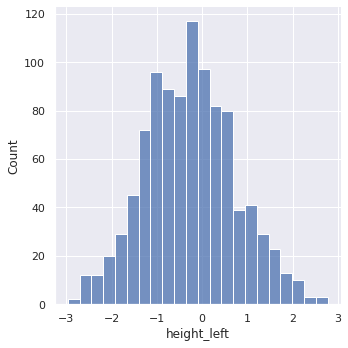

In [549]:
sns.displot(df_norm['height_left'][df_norm['is_genuine']== True])

In [550]:
print("coef d'asymétrie: " + str(round(df_norm['height_left'][df_norm['is_genuine']== True].skew(),2)))

coef d'asymétrie: 0.15


In [551]:
print("coef de kurtosis: " + str(round(df_norm['height_left'][df_norm['is_genuine']== True].kurtosis(),2)))

coef de kurtosis: -0.12


**Cette distributuon est tout de même symétrique.**

## Carte thermique de corrélation triangulaire

Text(0.5, 1.0, 'Explorer les données avec carte thermique de corrélation triangulaire')

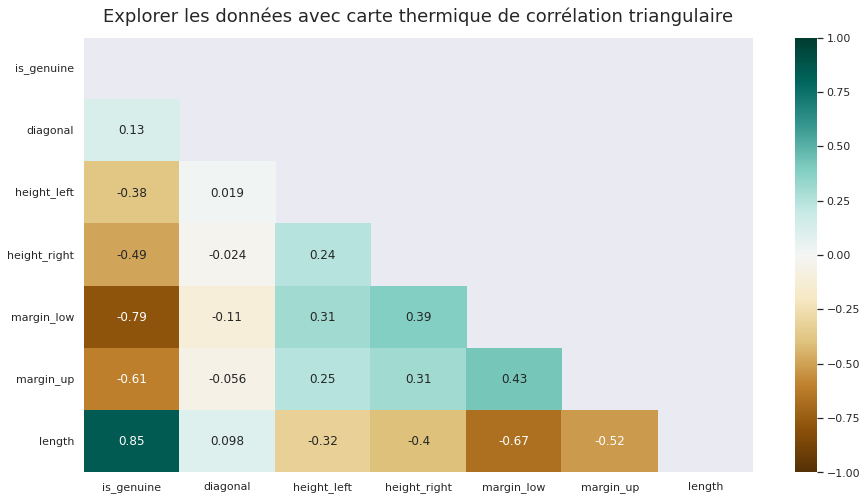

In [552]:
# Créer le graphique de heatmap de corrélation triangle
sns.set(rc = {'figure.figsize':(15,8)})
mask = np.triu(np.ones_like(df_norm.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df_norm.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Explorer les données avec carte thermique de corrélation triangulaire', fontdict={'fontsize':18}, pad=16)

Il y a des corrélations fortes avec les groupes (colonne: 'is_genuine') et les autres variables sauf 'diagonal'.

## ACP

### Explained variance ratio

In [553]:
# Vérifier le nombre de variances comme 7
df_norm.shape

(1500, 7)

In [554]:
# Le nombre de composante comme 7
num_components = 7

# Créer le modèle de ACP
pca = PCA(n_components=num_components)

# Fit le modèle avec les données normalisées
pca.fit(df_norm)

PCA(n_components=7)

In [555]:
# Explained_variance_ratio
pca.explained_variance_ratio_.round(2)

array([0.45, 0.16, 0.13, 0.11, 0.09, 0.05, 0.01])

In [556]:
# Explained_variance_ratio après cumsum
pca.explained_variance_ratio_.cumsum().round(2)

array([0.45, 0.61, 0.74, 0.85, 0.94, 0.99, 1.  ])

### Scree Plot

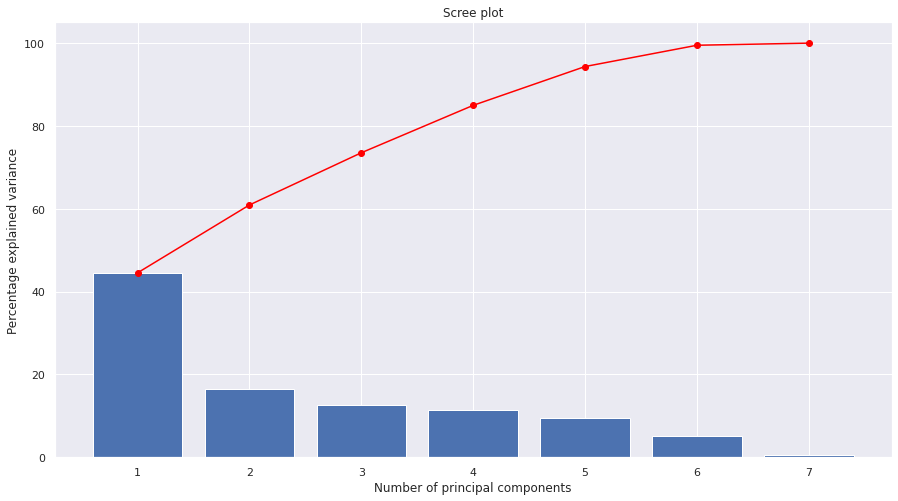

In [557]:
# La formule de Scree Plot de ACP
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

plt.figure(figsize=(15, 8))
display_scree_plot(pca)

<b> Les 3 premierères composantes principaux presentent presque 80% de information (basé sur la loi de Pareto)

### Analyser les 3 PCs

In [558]:
# Les 3 pc
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]

[Text(0, 0, 'is_genuine'),
 Text(0, 0, 'diagonal'),
 Text(0, 0, 'height_left'),
 Text(0, 0, 'height_right'),
 Text(0, 0, 'margin_low'),
 Text(0, 0, 'margin_up'),
 Text(0, 0, 'length')]

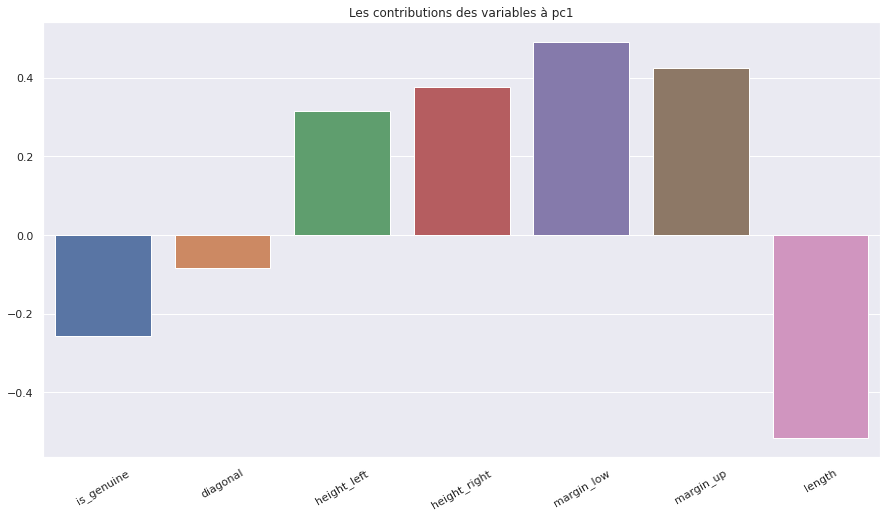

In [559]:
# Vérifier les contributions des variables à pc1
plt.figure()
plt.title('Les contributions des variables à pc1')
x = df_norm.columns
y1 = pc1
ax1 = sns.barplot(x=x, y=y1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

[Text(0, 0, 'is_genuine'),
 Text(0, 0, 'diagonal'),
 Text(0, 0, 'height_left'),
 Text(0, 0, 'height_right'),
 Text(0, 0, 'margin_low'),
 Text(0, 0, 'margin_up'),
 Text(0, 0, 'length')]

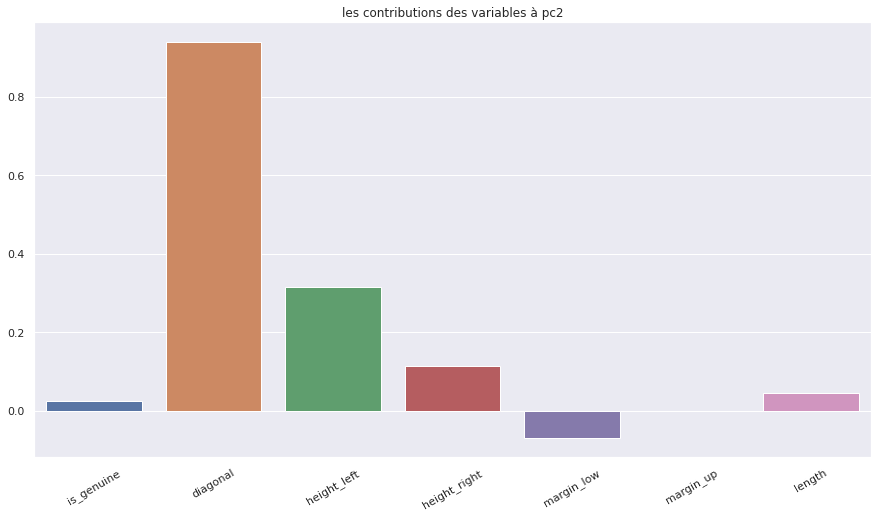

In [560]:
# Vérifier les contributions des variables à pc2
plt.figure()
plt.title('les contributions des variables à pc2')
x = df_norm.columns
y1 = pc2
ax1 = sns.barplot(x=x, y=y1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

[Text(0, 0, 'is_genuine'),
 Text(0, 0, 'diagonal'),
 Text(0, 0, 'height_left'),
 Text(0, 0, 'height_right'),
 Text(0, 0, 'margin_low'),
 Text(0, 0, 'margin_up'),
 Text(0, 0, 'length')]

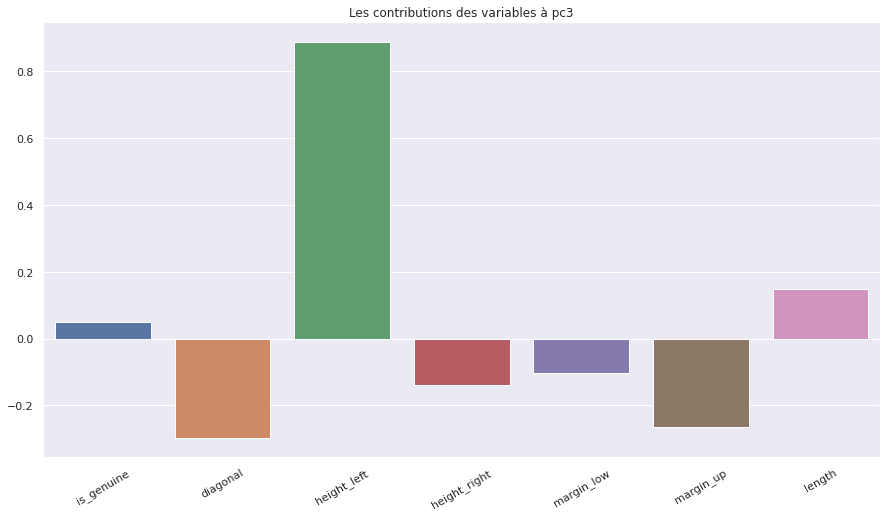

In [561]:
# Vérifier les contributions des variables à pc3
plt.figure()
plt.title('Les contributions des variables à pc3')
x = df_norm.columns
y1 = pc3
ax1 = sns.barplot(x=x, y=y1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

### Cercle de corrélation

In [562]:
# La formule de Cercle de corrélation
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)

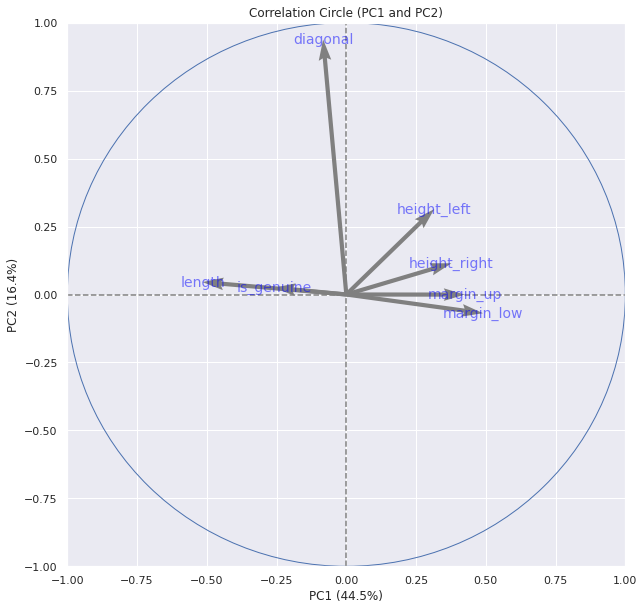

In [563]:
# Créer le cercle de corrélation
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(0,1)], labels = np.array(df_norm.columns)) 

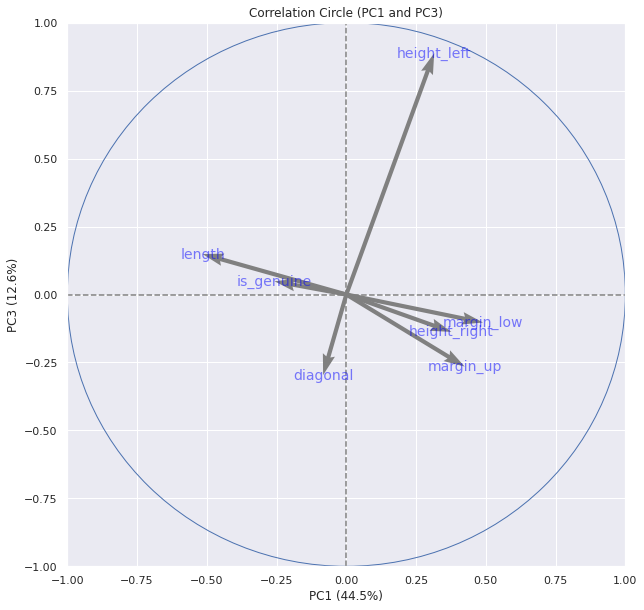

In [564]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(0,2)], labels = np.array(df_norm.columns)) 

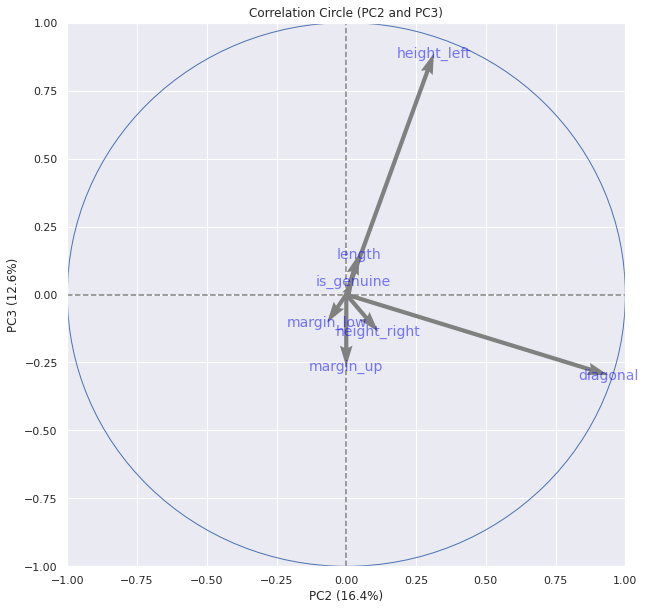

In [565]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(1,2)], labels = np.array(df_norm.columns)) 

**Comprendre les variables**

*   Il y a de corrélation avec 'is_genuine' et 'length'.
*   Il y a de corrélation négative avec 'is_genuine', 'margin_low' et 'margin_up'.




# Régression logistique classique

**Explication la méthode:**

La régression logistique nous permettra de traiter un cas de classification supervisée, c'est-à-dire un cas où on est en train de modéliser une variable qualitative (dans notre case, une variable binaire comme True et False) par des variables explicatives (les dimensions géométriques d’un billet).

**Conditions:**


*   loi de Bernoulli de paramètre p(x) dépendant de x : Y/X=x∼B(p(x))
*   La probabilité p(x) s'écrit sous la forme : p(x)=P(Y=1/X=x)=exp(β1+β2x)1+exp(β1+β2x)

## Créer modèles

### Retirer les variables non significatives

### Tous les variables

In [566]:
reg = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', 
              data = df_norm, family=sm.families.Binomial()).fit()
print(reg.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.466
Date:                                       Thu, 15 Sep 2022   Deviance:                       78.932
Time:                                               19:13:27   Pearson chi2:                 2.79e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

**La P valeur de 'diagonal' est beaucoup plus que 0.05. On le retire comme une variable non significative.**

### Retirer 'diagonal'

In [567]:
reg2 = smf.glm('is_genuine~height_right+height_left+margin_low+margin_up+length', 
              data = df_norm, family=sm.families.Binomial()).fit()
print(reg2.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1494
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.495
Date:                                       Thu, 15 Sep 2022   Deviance:                       78.990
Time:                                               19:13:28   Pearson chi2:                 2.79e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

## Séparer les dataset pour training et testing

In [568]:
# Séparer les dataset pour training et testing
X_lr = df_norm.drop(columns = ['is_genuine', 'diagonal'])
y_lr = df_norm['is_genuine']

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr, y_lr, test_size = 0.3)

In [569]:
# Vérifier les shapes de chaque dataset
print('X_lr_train shape: ' + str(X_lr_train.shape))
print('X_lr_test shape: ' + str(X_lr_test.shape))
print('y_lr_train shape: ' + str(y_lr_train.shape))
print('y_lr_test: ' + str(y_lr_test.shape))

X_lr_train shape: (1050, 5)
X_lr_test shape: (450, 5)
y_lr_train shape: (1050,)
y_lr_test: (450,)


In [570]:
# Créer la modèle régression logistique classique
Logreg = LogisticRegression().fit(X_lr_train, y_lr_train)

# Vérifier les scores
print("Training set score: {:.3f}".format(Logreg.score(X_lr_train, y_lr_train)))
print("Test set score: {:.3f}".format(Logreg.score(X_lr_test, y_lr_test)))

Training set score: 0.990
Test set score: 0.996


## Métriques d'évaluation

### Matrice de confusion

La matrice de confusion:
[[142   1]
 [  1 306]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



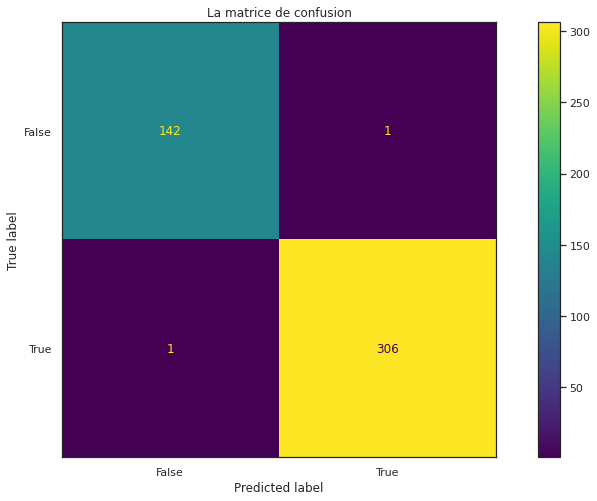

In [571]:
# Vérifier la matrice de confusion
y_predict_lr = Logreg.predict(X_lr_test)
confusion_lr = confusion_matrix(y_lr_test, y_predict_lr)
print('La matrice de confusion:\n{}'.format(confusion_lr))

sns.set_theme(style="white", palette=None)
plot_confusion_matrix(Logreg, X_lr_test, y_lr_test)  
plt.title('La matrice de confusion')
plt.show()

### Accuracy score

In [572]:
# Accuracy score
print('Note de précision: ' + str(accuracy_score(y_lr_test, y_predict_lr).round(3)))

Note de précision: 0.996


### Rapport de classification

In [573]:
print(classification_report(y_lr_test, y_predict_lr, target_names=['False', 'True']))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       143
        True       1.00      1.00      1.00       307

    accuracy                           1.00       450
   macro avg       0.99      0.99      0.99       450
weighted avg       1.00      1.00      1.00       450



### Courbe ROC

La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décision ss . L'aire sous la courbe ROC , l' AUC (Area Under the ROC ), est une mesure de la qualité de la classification qui varie entre :

- AUC=1/2 : dans le pire des cas ;
- AUC=1 : dans le meilleur des cas.

<Figure size 1440x720 with 0 Axes>

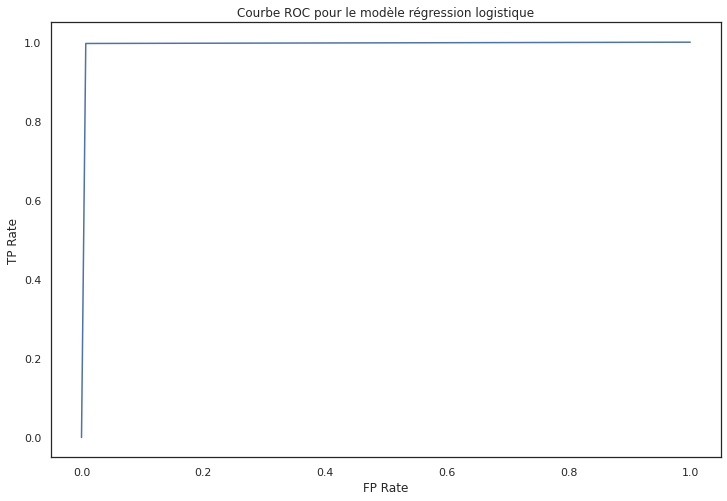

<Figure size 1440x720 with 0 Axes>

In [574]:
# Calculer FP Rate et TP Rate
fpr, tpr, _ = roc_curve(y_lr_test, y_predict_lr)

# Créer le graphique
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.title('Courbe ROC pour le modèle régression logistique' )
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.figure(figsize=(20, 10))

# KMeans

Explication la méthode:

*   Placer les centroïdes aléatoirement dans l'espace
*   Prendre chaque point du nuage et lui associee le cluster du centroïde dont il est le plus proche. On obtient donc K groupes.
*   Recalculer les centroïdes de chaque groupe quand les centroïdes bougent jusqu'à ce qu'ils ne bougent pas.



##La méthode Elbow



Text(0.5, 1.0, 'La méthode Elbow')

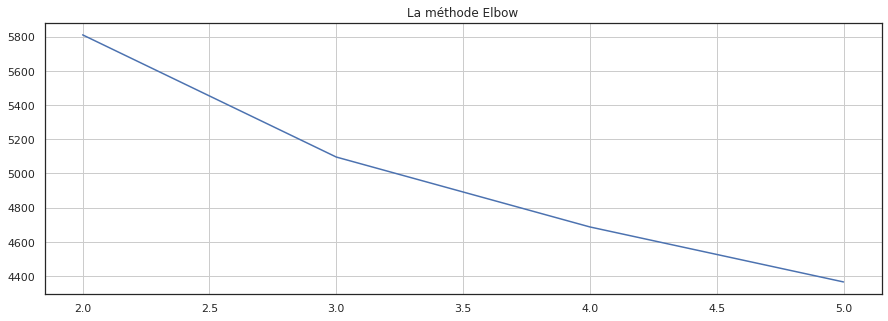

In [575]:
distorsions = []
num_clusters = [2, 3, 4, 5]

for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_norm)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(num_clusters, distorsions)
plt.grid(True)
plt.title('La méthode Elbow')

**On ne peut pas juger combien de groupes qu'on doit choisir par cette méthode.**

## Silhouette analyse

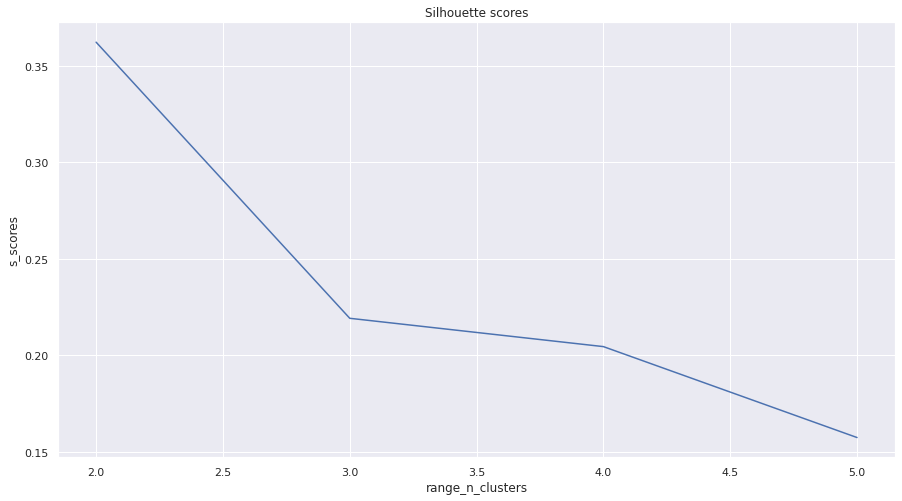

In [576]:
# Nombre de cluster
s_scores = []
range_n_clusters = [2, 3, 4, 5]

# Calculer silhouette score avec kmeans
for num_clusters in range_n_clusters:
    
    kmeans_sk = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans_sk.fit(df_norm)
    s_scores.append (silhouette_score(df_norm, kmeans_sk.labels_))
df_score = pd.DataFrame({'range_n_clusters': range_n_clusters,
             's_scores': s_scores})

sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(x= 'range_n_clusters', y = 's_scores', data = df_score)
plt.title('Silhouette scores')
plt.show()

**Choisir 2 comme le nombre de clusters**

## Créer models

In [577]:
# Créer le dataframe pour les variables
df_var = df_norm[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

In [578]:
# Créer le modèle
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_var) 
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [579]:
# Faire la prévision
km_predict = kmeans.predict(df_var)
km_predict

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [580]:
# Vérifier les centres de cluster
kmeans_cluster_centers = kmeans.cluster_centers_

In [581]:
# Ajouter les étiquettes au dataframe
df_norm['Cluster'] = km_predict
df_norm.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster
0,True,-0.486540,2.774123,3.163240,0.051286,-1.128325,0.173651,1
1,True,-1.633729,-2.236535,-0.799668,-1.078937,-0.696799,0.471666,0
2,True,2.397823,1.504756,-1.291191,-0.129549,-0.912562,0.551901,0
3,True,-1.961498,-0.399294,0.060498,-1.304982,-0.610494,0.953075,0
4,True,-0.748754,0.836669,-1.414072,-0.672057,1.417677,-0.158750,0


In [582]:
# Compter les nombre de chaque cluster
df_count = df_norm.groupby('Cluster')['Cluster'].count()
df_count

Cluster
0    1003
1     497
Name: Cluster, dtype: int64

In [583]:
a = df_norm[df_norm['Cluster'] == 0]['Cluster'].count()
b = df_norm[df_norm['Cluster'] == 1]['Cluster'].count()

Parce qu'il y a 1000 vrais billets et 500 faux billets, le plus = True, le moindre = False

In [584]:
# Changer les noms de clusters
if a > b:
  df_norm['Cluster'] = df_norm['Cluster'].map({0: True, 1: False})
else:
  df_norm['Cluster'] = df_norm['Cluster'].map({0: False, 1: True})
df_norm['Cluster']

0       False
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: Cluster, Length: 1500, dtype: bool

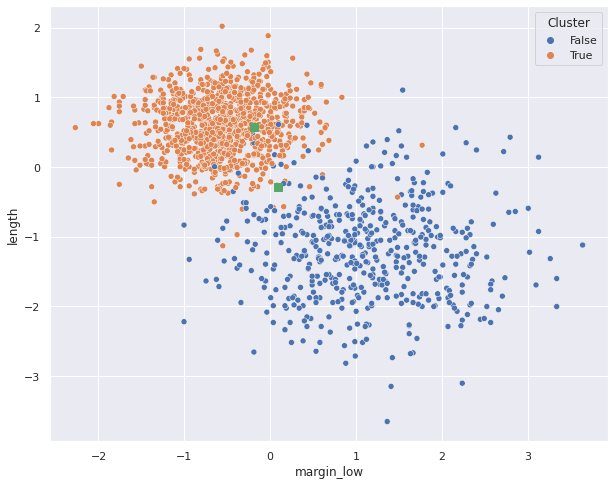

In [585]:
# Présenter les centroids et les clusters avec margin_low et length
plt.figure(figsize=(10,8))
sns.scatterplot( x = 'margin_low', y = 'length', hue = df_norm['Cluster'], data = df_norm)
plt.plot(kmeans_cluster_centers[:,0], kmeans_cluster_centers[:,1], 'sg',markersize = 8)
plt.show()

In [586]:
pcs = pd.DataFrame(list(zip(df_norm['margin_low'], df_norm['length'], df_norm['margin_up'], df_norm['Cluster'])),columns =['margin_low', 'length', 'margin_up', 'Cluster']) 
fig = px.scatter_3d(pcs, x='margin_low', y='length', z='margin_up',color='Cluster')
fig.show()

## Métriques d'évaluation

### Matrice de confusion

Matrice de confusion:
[[487  13]
 [ 10 990]]


Text(0.5, 1.0, 'Matrice de confusion')

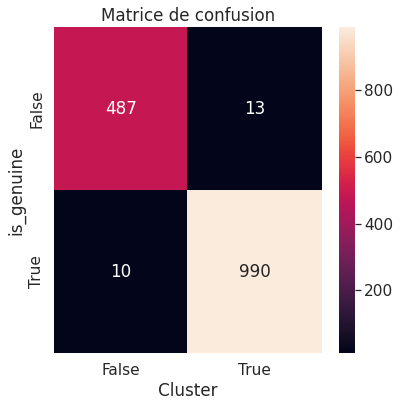

In [587]:
confusion_kmeans = confusion_matrix(df_norm['is_genuine'], df_norm['Cluster'])
print('Matrice de confusion:\n{}'.format(confusion_kmeans))

conf_crosstab = pd.crosstab(df_norm['is_genuine'], df_norm['Cluster'])

sns.set(rc={'figure.figsize': (6, 6)}, font_scale=1.4)
sns.heatmap(conf_crosstab, annot = True, fmt='')
plt.title('Matrice de confusion')

### Courbe ROC

<Figure size 1440x720 with 0 Axes>

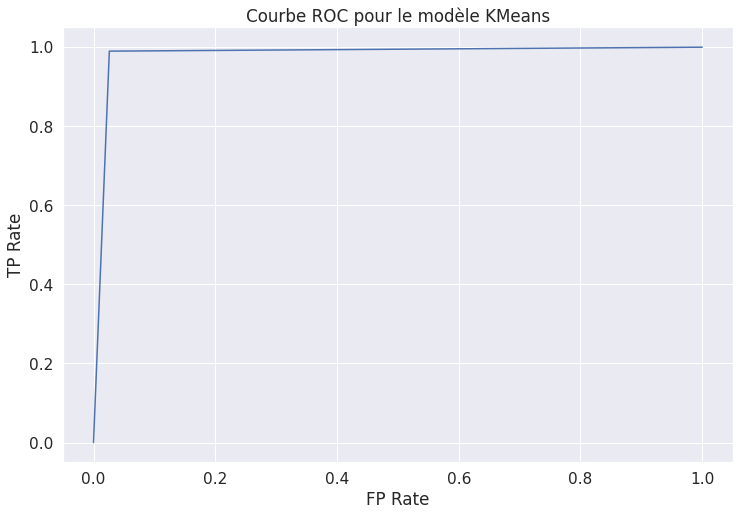

<Figure size 1440x720 with 0 Axes>

In [588]:
# Calculer FP Rate et TP Rate
fpr_km, tpr_km, _ = roc_curve(df_norm['is_genuine'], df_norm['Cluster'])

# Créer le graphique
plt.figure(figsize=(12, 8))
plt.plot(fpr_km, tpr_km)
plt.title('Courbe ROC pour le modèle KMeans' )
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.figure(figsize=(20, 10))

# Modèle final et l'application

## Choisir le modèle

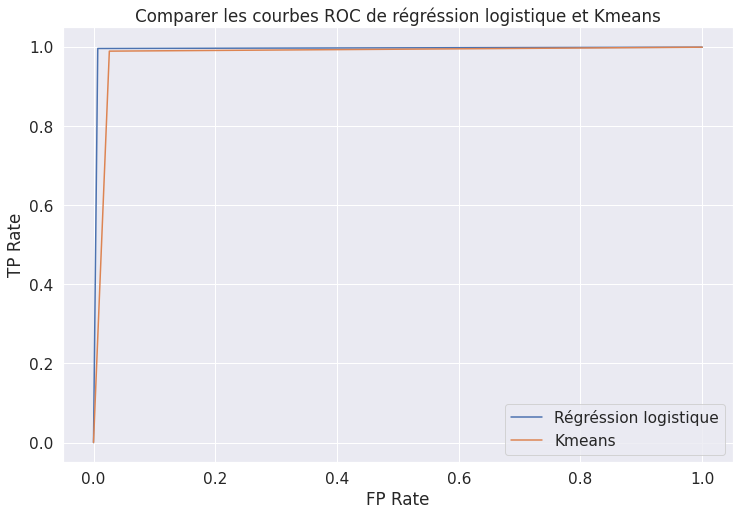

In [589]:
# Créer le graphique
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label = 'Régréssion logistique')
plt.plot(fpr_km, tpr_km, label = 'Kmeans')
plt.title('Comparer les courbes ROC de régréssion logistique et Kmeans' )
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend()

## Exporter le modèle avec Joblib

Le modèle régréssion logistique a de meilleures performances que le modèle Kmeans. Choisir le modèle régréssion logistique comme notre modèle de prévision.

In [590]:
jl.dump(Logreg, '/content/drive/MyDrive/Colab Notebooks/P10/LIANG_Xiuting_3_modele_logreg_code_082022.pkl')

['/content/drive/MyDrive/Colab Notebooks/P10/LIANG_Xiuting_3_modele_logreg_code_082022.pkl']

## Tester le modèle avec le fichier de production


In [591]:
df_production = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P10/billets_production.csv', index_col = 'id', 
                            usecols = ['id','height_left', 'height_right', 'margin_low', 'margin_up', 'length'])
df_production.head()

,height_left,height_right,margin_low,margin_up,length
id,,,,,
A_1,104.01,103.54,5.21,3.30,111.42
A_2,104.17,104.13,6.00,3.31,112.09
A_3,104.58,104.29,4.99,3.39,111.57
A_4,104.55,104.34,4.44,3.03,113.20
A_5,103.63,103.56,3.77,3.16,113.33


In [592]:
# Centrage et réduction
df_scale_pro = df_production.copy()

# Sélectionner que les colonnes numériques
numeric_range = ['height_left', 'height_right', 'margin_low', 'margin_up', 'length']
scaled_pro = preprocessing.StandardScaler().fit_transform(df_production[numeric_range])
df_scale_pro[numeric_range] = scaled_pro

# Vérifier les distributions de données
df_scale_pro.describe()

,height_left,height_right,margin_low,margin_up,length
count,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
mean,-4.809486e-14,-5.657697e-14,-5.773160e-16,3.486100e-15,-3.552714e-15
std,1.118034e+00,1.118034e+00,1.118034e+00,1.118034e+00,1.118034e+00
min,-1.574388e+00,-1.228900e+00,-1.485686e+00,-1.629382e+00,-1.124014e+00
25%,-5.022241e-01,-1.172007e+00,-5.905335e-01,-6.110181e-01,-9.370937e-01
50%,-5.078670e-02,4.494589e-01,1.442932e-01,4.856811e-01,-2.891034e-01
75%,1.021377e+00,9.046072e-01,4.382239e-01,5.640167e-01,1.094107e+00
max,1.106022e+00,1.046841e+00,1.493702e+00,1.190702e+00,1.256104e+00


### Logistic Regression

In [593]:
Logreg.predict(df_scale_pro)

array([False, False, False,  True,  True])

In [594]:
Logreg.predict_proba(df_scale_pro)

array([[9.37121469e-01, 6.28785308e-02],
       [9.88263369e-01, 1.17366311e-02],
       [9.92707399e-01, 7.29260060e-03],
       [1.71643285e-04, 9.99828357e-01],
       [3.17324471e-06, 9.99996827e-01]])

In [595]:
Logreg.predict_proba(df_scale_pro).round(2)

array([[0.94, 0.06],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.  , 1.  ]])

In [596]:
df_production['resultat_logreg'] = Logreg.predict(df_scale_pro)
df_production['probabilité'] = Logreg.predict_proba(df_scale_pro).round(6)[:,1:2]
df_production

,height_left,height_right,margin_low,margin_up,length,resultat_logreg,probabilité
id,,,,,,,
A_1,104.01,103.54,5.21,3.30,111.42,False,0.062879
A_2,104.17,104.13,6.00,3.31,112.09,False,0.011737
A_3,104.58,104.29,4.99,3.39,111.57,False,0.007293
A_4,104.55,104.34,4.44,3.03,113.20,True,0.999828
A_5,103.63,103.56,3.77,3.16,113.33,True,0.999997


### Résultat

In [597]:
df_production[['resultat_logreg', 'probabilité']]

,resultat_logreg,probabilité
id,,
A_1,False,0.062879
A_2,False,0.011737
A_3,False,0.007293
A_4,True,0.999828
A_5,True,0.999997


In [598]:
df_result = df_production[['resultat_logreg', 'probabilité']].copy()
df_result['resultat_logreg'] = df_result['resultat_logreg'].astype(str)
df_result1 = df_result.groupby('resultat_logreg')['resultat_logreg'].count()
df_result1 = pd.DataFrame(df_result1)
df_result1

,resultat_logreg
resultat_logreg,
False,3
True,2


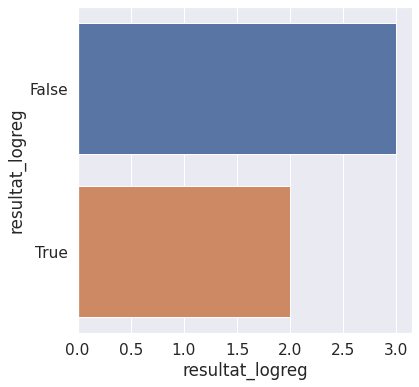

In [599]:
x = df_result1['resultat_logreg']
y = df_result1.index
sns.barplot(data = df_result1, x = df_result1['resultat_logreg'], y = df_result1.index)

# *Annexe

*   Trouver ci-joint 'LIANG_Xiuting_2_application_082022.ipynb' pour l'application

*   Trouver ci-joint 'LIANG_Xiuting_3_modele_logreg_code_082022.pkl' pour le modèle

*   Trouver ci-joint 'LIANG_Xiuting_4_web_application_code_082022.py' pour l'application web par Streamlit

